In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Frequency Analysis

In [2]:
# Multi frequency signal
def signal(x):
    return 2 * np.sin(5*x) + 8 * np.sin(10*x) + 5 * np.sin(15*x)

Text(0.5, 1.0, 'Multi-Frequency Signal')

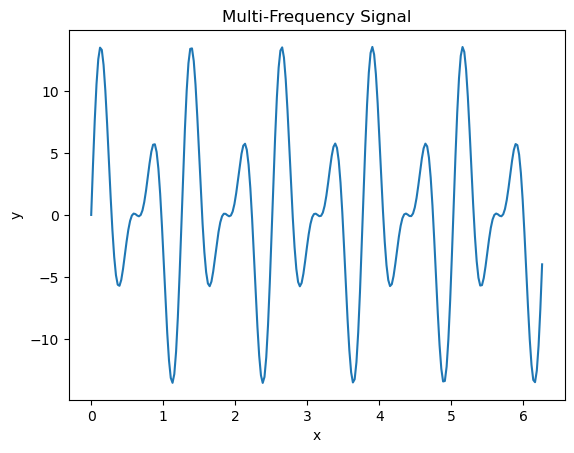

In [3]:
# Plot signal
length = 2*np.pi 
N_grid = 2**8

x = np.linspace(0, length, N_grid+1)
x = x[0:N_grid]

y = signal(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Multi-Frequency Signal")

Text(0.5, 1.0, 'Frequency Domain Representation')

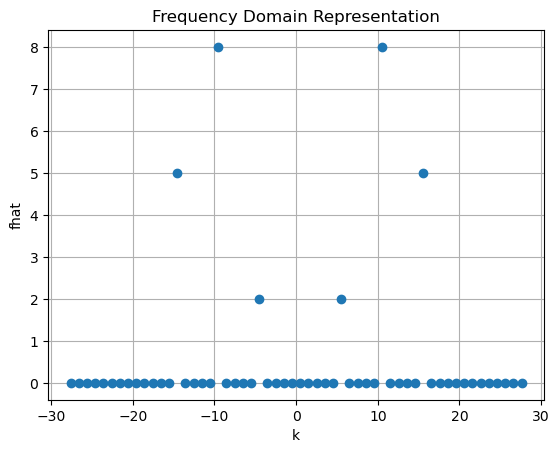

In [4]:
# Perform fft and plot frequencies
fhat = np.fft.fftshift(np.fft.fft(y))
k = np.linspace(-N_grid/2, N_grid/2, N_grid)
plt.plot(k[100:-100], np.abs((2/N_grid)*fhat)[100:-100], 'o')
plt.grid(True)
plt.xlabel("k")
plt.ylabel("fhat")
plt.title("Frequency Domain Representation")

# Image Denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 500, 3)


Text(0.5, 1.0, 'Noisy Image')

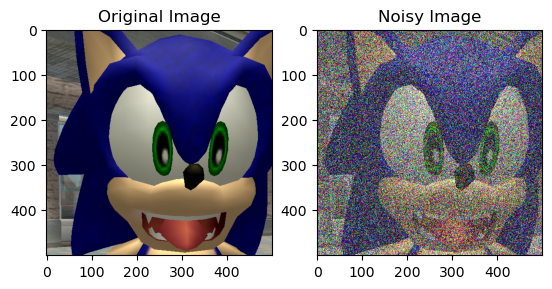

In [5]:
# Load the image and add noise
image = np.asarray(Image.open("sonichappy.png"))[0:500, 750:1250,:]
noise = image.std() * 3 * np.random.standard_normal(image.shape)
noisy_image = (image + noise) / 255
print(image.shape)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(noisy_image)
axs[1].set_title("Noisy Image")

In [6]:
# Compute fft on noisy image
f_hat_sig = np.fft.fftshift(np.fft.fftn(noisy_image, axes=(0,1,2)))
log_f = np.log(np.abs(f_hat_sig))

In [7]:
# Compute fft on original image
f_hat_img = np.fft.fftshift(np.fft.fftn(image, axes=(0,1,2)))
log_f_img = np.log(np.abs(f_hat_img))

(500, 500, 3)


Text(0.5, 1.0, 'Blue Channel')

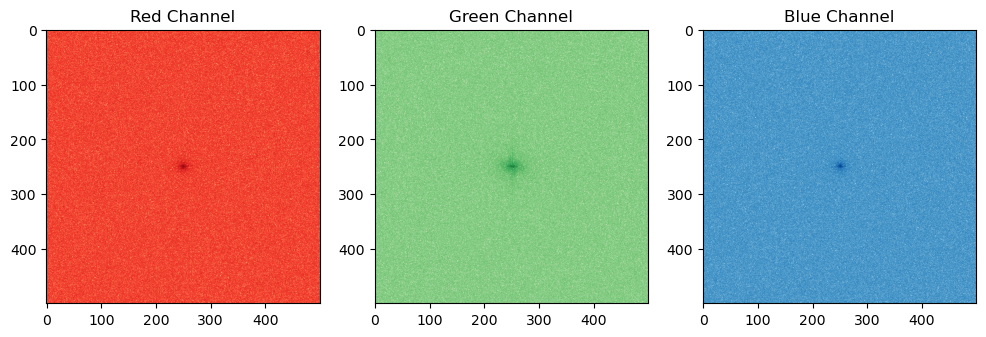

In [8]:
# Plot noisy image fft for each color channel
print(log_f.shape)
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(log_f[:,:,0], cmap="Reds")
axs[0].set_title("Red Channel")
axs[1].imshow(log_f[:,:,1], cmap="Greens")
axs[1].set_title("Green Channel")
axs[2].imshow(log_f[:,:,2], cmap="Blues")
axs[2].set_title("Blue Channel")

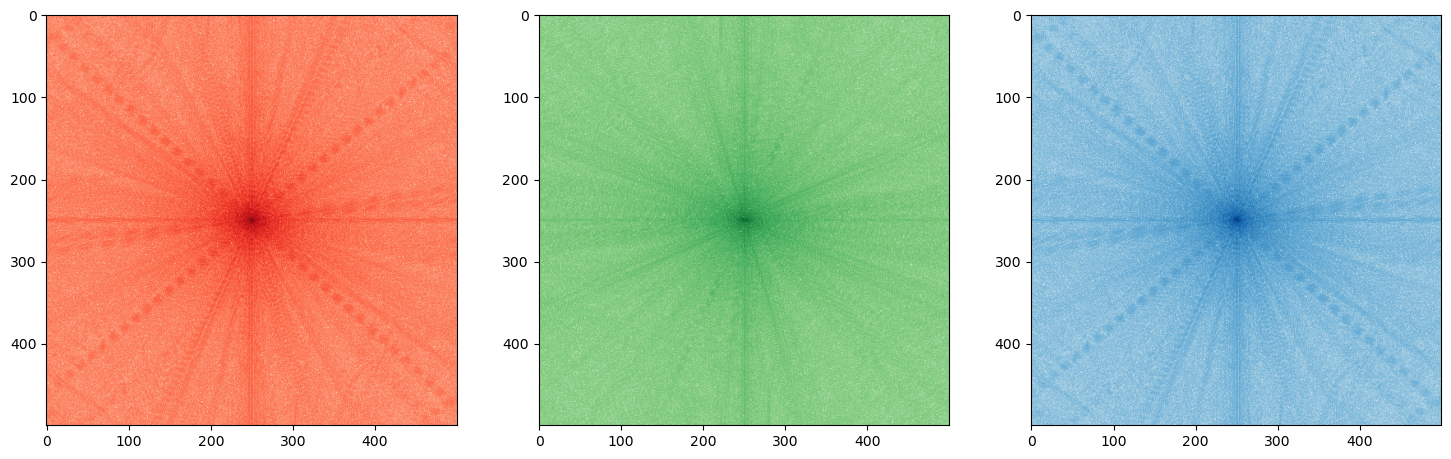

In [9]:
# Plot normal image fft for each channel
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(log_f_img[:,:,0], cmap="Reds")
axs[1].imshow(log_f_img[:,:,1], cmap="Greens")
axs[2].imshow(log_f_img[:,:,2], cmap="Blues")

In [10]:
# 2D Gaussian Function

def gaussian_2d(x, y, mu_x, mu_y, sigma):
    return np.exp(-((x-mu_x)**2 + (y-mu_y)**2) / (2 * sigma**2))

0.9997211466556898


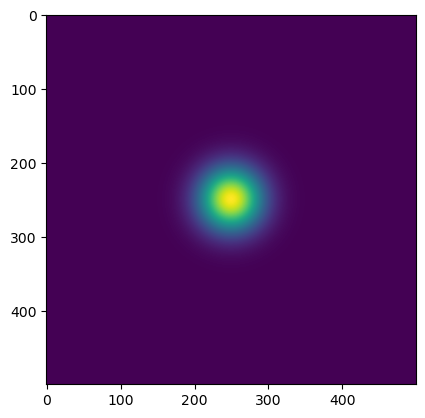

In [11]:
# Plot gaussian filter
side = image.shape[0]
channels = image.shape[2]
axis = np.linspace(-side/2, side/2, side)
X, Y = np.meshgrid(axis, axis)

gfilter = gaussian_2d(X, Y, 0, 0, 30)
rgb_filter = np.repeat(gfilter[:, :, np.newaxis], 3, axis=2)
plt.imshow(gfilter)

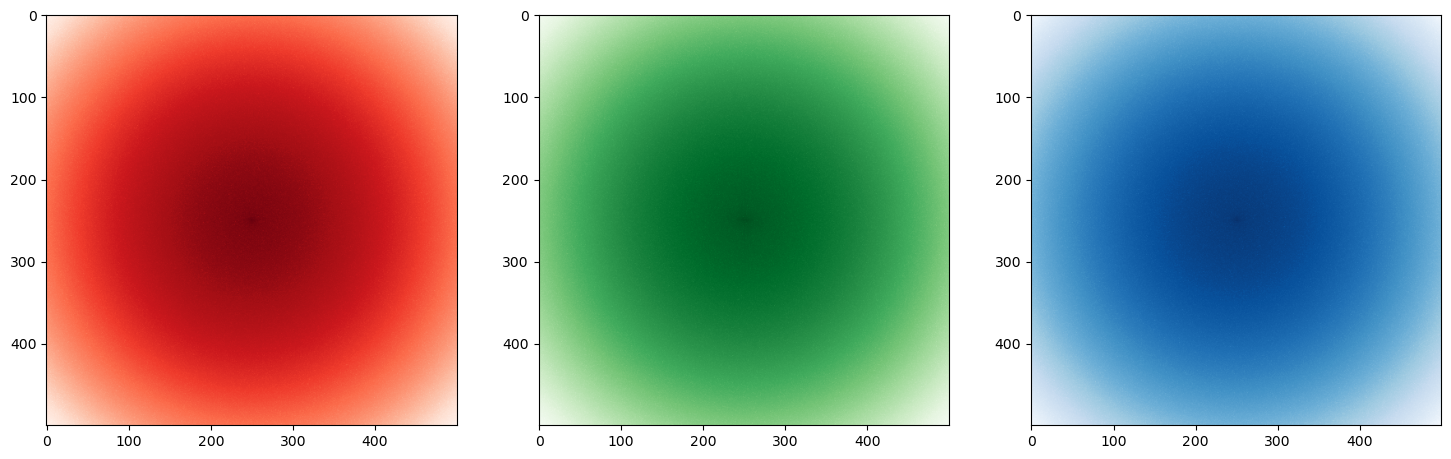

In [12]:
# Plot fft of noisy image after filter has been applied
log_f_filt = np.log(np.abs(rgb_filter * f_hat_sig))
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(log_f_filt[:,:,0], cmap="Reds")
axs[1].imshow(log_f_filt[:,:,1], cmap="Greens")
axs[2].imshow(log_f_filt[:,:,2], cmap="Blues")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Denoised Image')

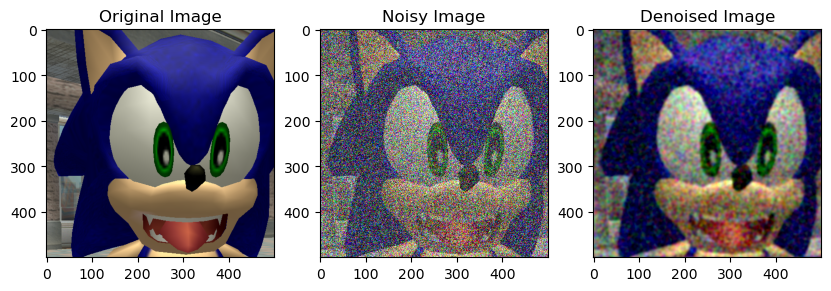

In [13]:
# Plot original, noisy, and denoised image
denoised = np.real(np.fft.ifftn(np.fft.ifftshift(rgb_filter * f_hat_sig)))

fig, axs = plt.subplots(1, 3, figsize=(10, 25))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(noisy_image)
axs[1].set_title("Noisy Image")
axs[2].imshow(denoised)
axs[2].set_title("Denoised Image")

# Principal Components and Image Compression

In [14]:
# Load Images

images = []
for f in os.listdir("images"):
    path = os.path.join("images", f)
    img = np.array(Image.open(path))
    images.append(img.reshape(-1, img.shape[-1]))
images = np.array(images)

In [96]:
# Perform PCA on each color channel
pca_objs = []
pca_comps = []
for i in range(4):
    pca = PCA()
    pca.fit(images[:,:,i] / 255)
    pca_objs.append(pca)
    pca_comps.append(pca.components_)
pca_objs = np.array(pca_objs)
pca_comps = np.array(pca_comps)


In [17]:
# Function for scaling PCA values so they can be displayed as an rgb image
def scale_rgba(array):
    min_val = np.min(array)
    max_val = np.max(array)
    scaled_array = (array - min_val) / (max_val - min_val) * 255
    return scaled_array.astype(np.uint8)

(4, 809, 14400)


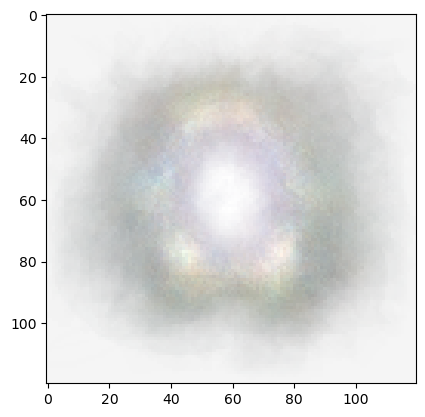

In [97]:
print(pca_comps.shape)
# First PCA Mode:
mode = 0
t_pca_img = scale_rgba(pca_comps[:,0,:].T.reshape((120, 120, 4)))
plt.imshow(t_pca_img)

Text(0, 0.5, 'Cumulative Energy')

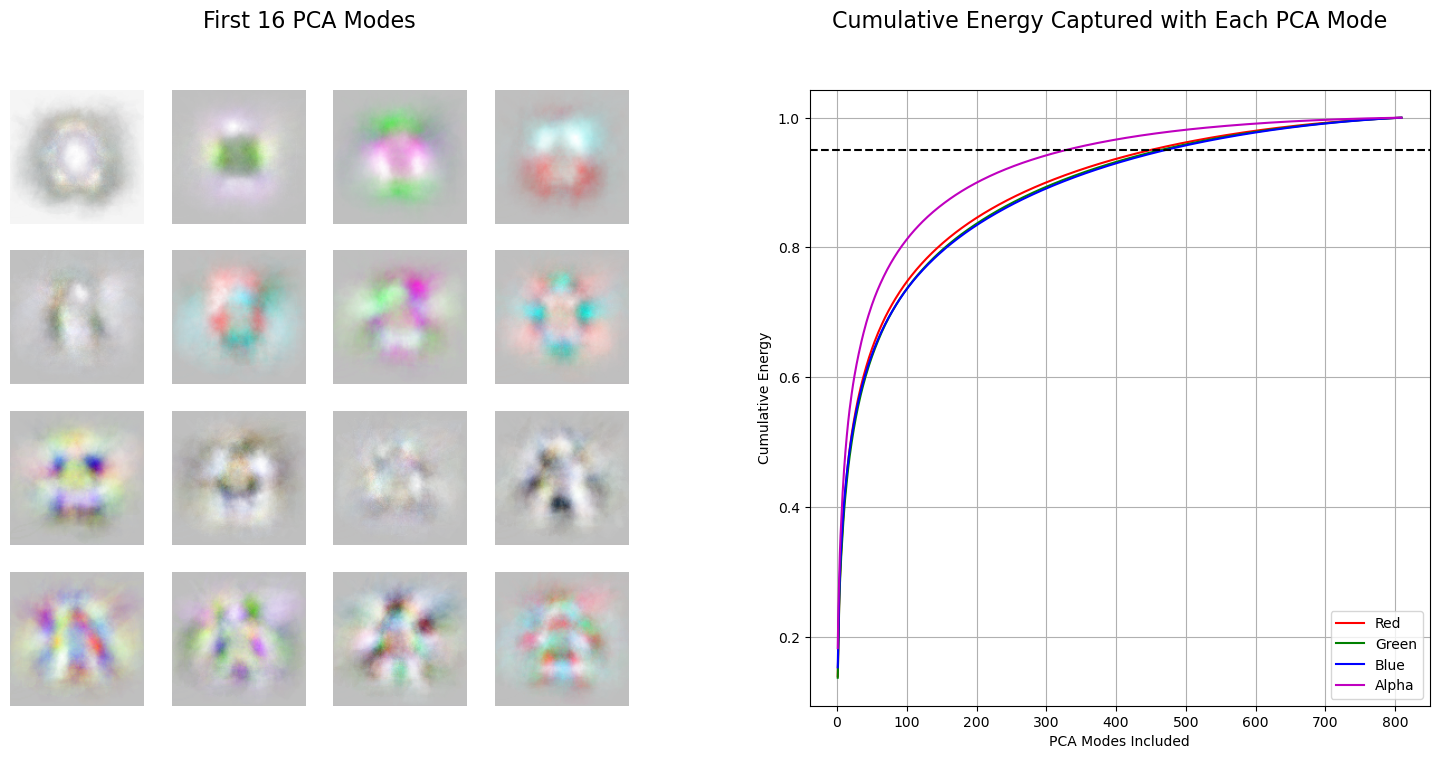

In [103]:
# Plot the first 16 PCA Modes

fig = plt.figure(figsize=(16, 8))
subfigs = fig.subfigures(1, 2)

N = 4
ax = subfigs[0].subplots(N, N)
for i in range(N):
    for j in range(N):
        ax[i,j].imshow(scale_rgba(pca_comps[:,N*i+j,:].T.reshape((120, 120, 4))))
        ax[i,j].axis("off")
subfigs[0].suptitle("First 16 PCA Modes", size=16)

# Plot the cumulative energy captured with each PCA mode
clrs = ["r", "g", "b", "m"]
labels = ["Red", "Green", "Blue", "Alpha"]
stop = 600
singulars = [p.singular_values_ for p in pca_objs]
frame = subfigs[1].subplots(1, 1)
for i, svs in enumerate(singulars):
    cum_e = np.cumsum(np.power(svs,2)/np.sum(np.power(svs,2)))
    frame.plot(np.arange(1, len(cum_e) + 1, 1), cum_e, clrs[i], label=labels[i])
frame.axhline(y=0.95, color="k", linestyle="--")
frame.grid(True)
frame.legend()
subfigs[1].suptitle("Cumulative Energy Captured with Each PCA Mode", size=16)
frame.set_xlabel('PCA Modes Included')
frame.set_ylabel('Cumulative Energy')


In [40]:
k90 = 500

In [85]:
pca_k90_objs = []
pca_k90_comps = []
reconstructions = []
for i in range(4):
    pca = PCA(n_components=k90)
    channel = images[:,:,i] / 255
    pca.fit(channel)
    pca_k90_objs.append(pca)
    pca_k90_comps.append(pca.components_)
    imtrunc = pca.transform(channel)
    recon = pca.inverse_transform(imtrunc)
    reconstructions.append(recon)

pca_k90_objs = np.array(pca_k90_objs)
pca_k90_comps = np.array(pca_k90_comps)
reconstructions = np.array(reconstructions).transpose((1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 0.98, '500 Mode Approximated Images')

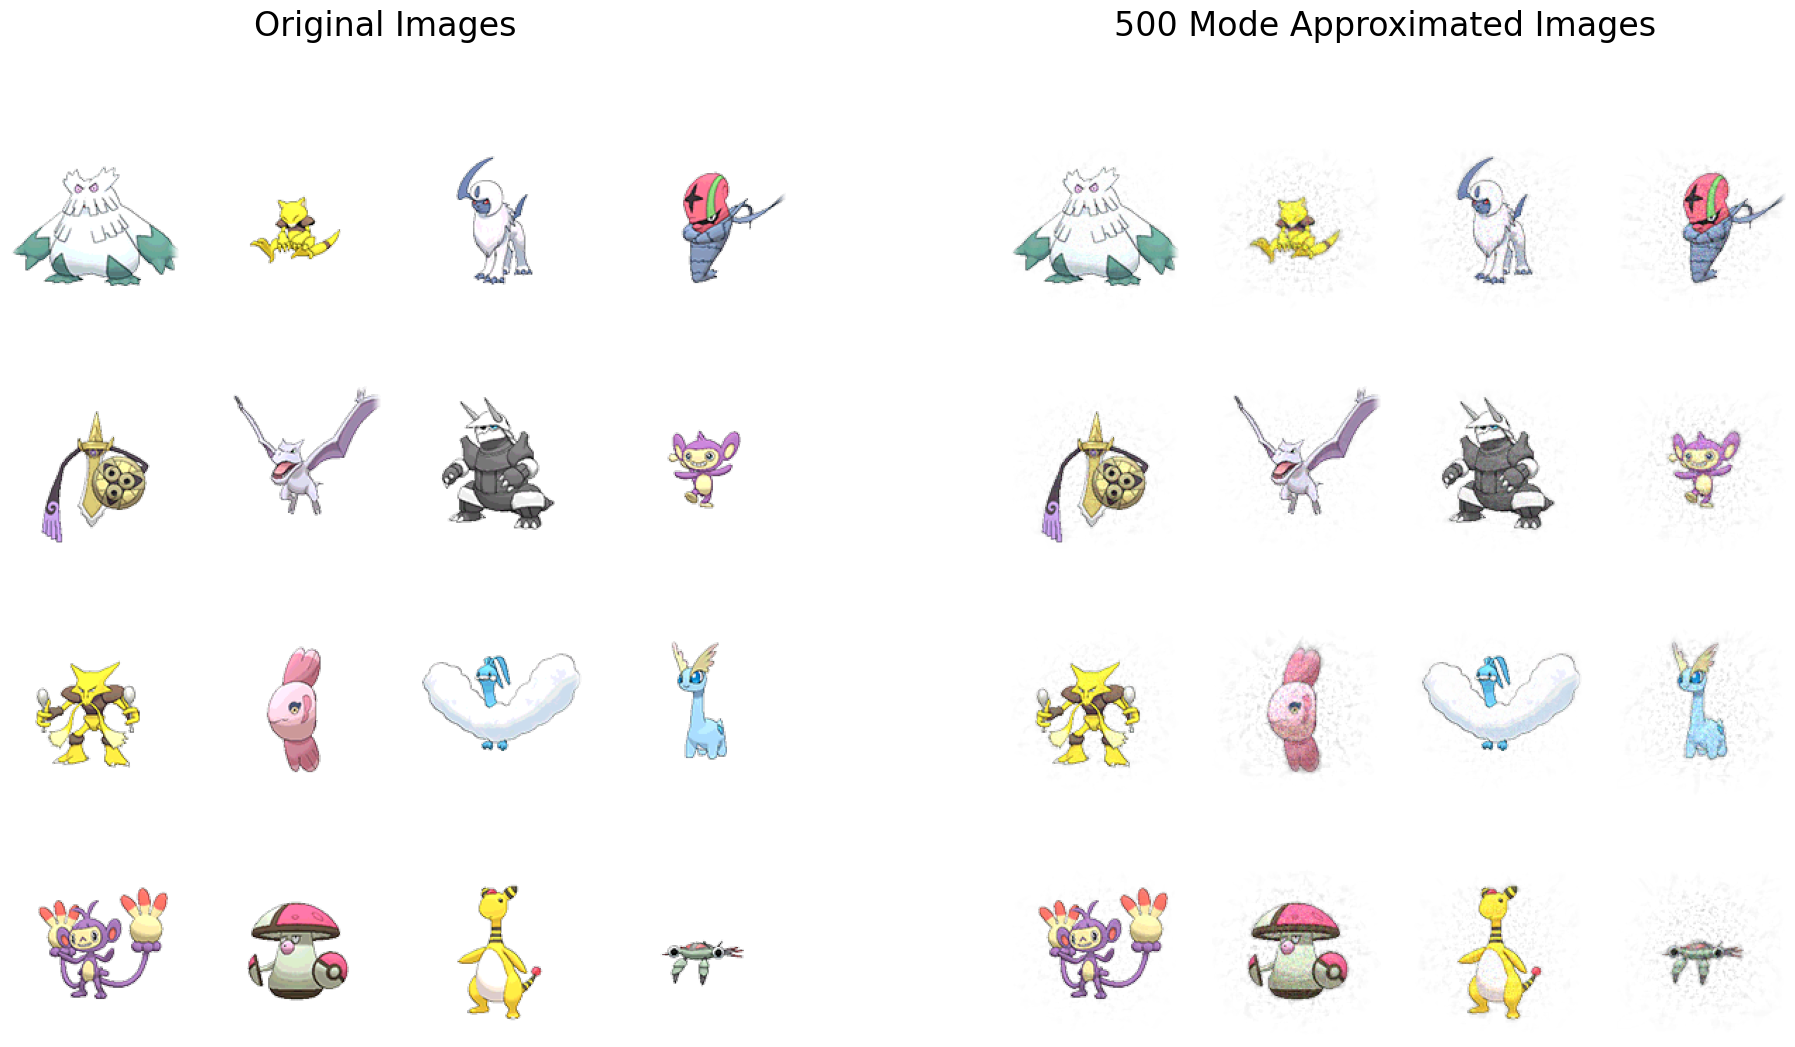

In [95]:
# Compare Approximated Training Images to Original Images

fig = plt.figure(figsize=(20, 12))
subfigs = fig.subfigures(1, 2)

N = 4
# Original
axs = subfigs[0].subplots(N, N)
for i in range(N):
    for j in range(N):
        axs[i,j].imshow(images[N*i+j].reshape((120, 120, 4)))
        axs[i,j].axis("off")

subfigs[0].suptitle("Original Images", fontsize=24)

# Approximated
axs = subfigs[1].subplots(N, N)
for i in range(N):
    for j in range(N):
        axs[i,j].imshow(reconstructions[(N)*i+j].reshape((120, 120, 4)))
        axs[i,j].axis("off")

subfigs[1].suptitle(str(k90) + " Mode Approximated Images", fontsize=24)
